# 목표
Detection of a shallow-buried rock obstruction using 2D full waveform inversion - Liu et al., 2021 처럼 지중 장애물이 있는 경우를 모사한다

In [61]:
import torch
import deepwave
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

from Tools.processing import normalized_shot_gather
from Tools.soft_dtw_cuda import SoftDTW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Tools import read, model, plot, processing, inv
import scipy
import random

from tqdm import tqdm

In [62]:
offset = 5
src_spacing = 16
n_gp = 24
gp_spacing = 1

x_m = 45
z_m = 20
dx = 0.2

nx = int(x_m/dx)
nz = int(z_m/dx)

In [63]:
print(nx)

225


In [64]:
shots = torch.tensor([5, 21, 38]).to(device=device)/dx
receiver = torch.arange(10, 34, gp_spacing).to(device=device)/dx

In [65]:
vs_back = 200
vp_back = 500
rho_back = 1800

vs_obs = 220
vp_obs = 500
rho_obs =2200

In [66]:
fs = 1000
dt = 1/fs
t= 0.5
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)

In [67]:
x= np.arange(0, x_m, dx)
z= np.arange(0, z_m, dx)
X, Z = np.meshgrid(x, z)

circle_center_x = x_m / 2  # x 중심
circle_center_z = 10  # 깊이 10m
circle_radius = 5  # 반지름 5m

# 장애물 영역 계산
circle_mask = (X - circle_center_x) ** 2 + (Z - circle_center_z) ** 2 <= circle_radius ** 2

vp_circle = torch.ones((nz, nx), device=device) * vp_back
vs_circle = torch.ones((nz, nx), device=device) * vs_back
rho_circle = torch.ones((nz, nx), device=device) * rho_back

vp_circle[circle_mask] = vp_obs
vs_circle[circle_mask] = vs_obs
rho_circle[circle_mask] = rho_obs

In [77]:
V_MAX = 300
V_MIN = 200
data_range = V_MAX - V_MIN

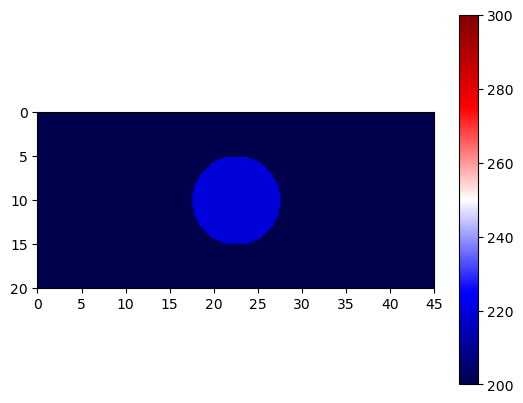

In [78]:
plt.figure()
plt.imshow(vs_circle.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar() 
plt.show()

In [79]:
vp_f, vs_inv, rho_f = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device)
vp_f[:,:] = vp_back
vs_inv[:,:] = vs_back
rho_f[:,:] = rho_back

In [80]:
n_shots = len(shots)
n_sources_per_shot = 1

f0 = 20
peak_time = 1.5/f0

source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots).unsqueeze(1)

In [81]:
receiver_locations = torch.zeros(n_shots, len(receiver), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receiver

In [82]:
obs = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_circle, vs_circle, rho_circle),
    grid_spacing=dx, dt=dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=shot,
    receiver_locations_y=receiver_locations,
    pml_freq=f0, pml_width=[0, 10, 10, 10]
)[-2]
obs = normalized_shot_gather(obs)

In [83]:
def csg(
    data, receiver, time,
    duration: float,
    title: str,
    color=None,
    second_data=None,
    second_color=None,
    show_legend: bool = True
):
    # numpy 변환
    if hasattr(data, 'detach'):
        data = data.detach().cpu().numpy()
    if second_data is not None and hasattr(second_data, 'detach'):
        second_data = second_data.detach().cpu().numpy()
    if hasattr(receiver, 'detach'):
        receiver = receiver.detach().cpu().numpy()

    dt      = time[1] - time[0]
    max_idx = int(duration / dt)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 합성파
    for i in range(data.shape[0]):
        trace = data[i, :max_idx]
        norm  = trace / np.max(np.abs(trace))
        ax.plot(receiver[i] + norm, time[:max_idx],
                color=color)

    # 관측파
    if second_data is not None:
        for i in range(second_data.shape[0]):
            trace = second_data[i, :max_idx]
            norm  = trace / np.max(np.abs(trace))
            ax.plot(receiver[i] + norm, time[:max_idx],
                    color=second_color, linestyle='--')

    ax.invert_yaxis()
    ax.set_xlabel("Offset (m)")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    if show_legend == True:
        ax.legend(loc='lower right')

    ax.grid(True)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.show()


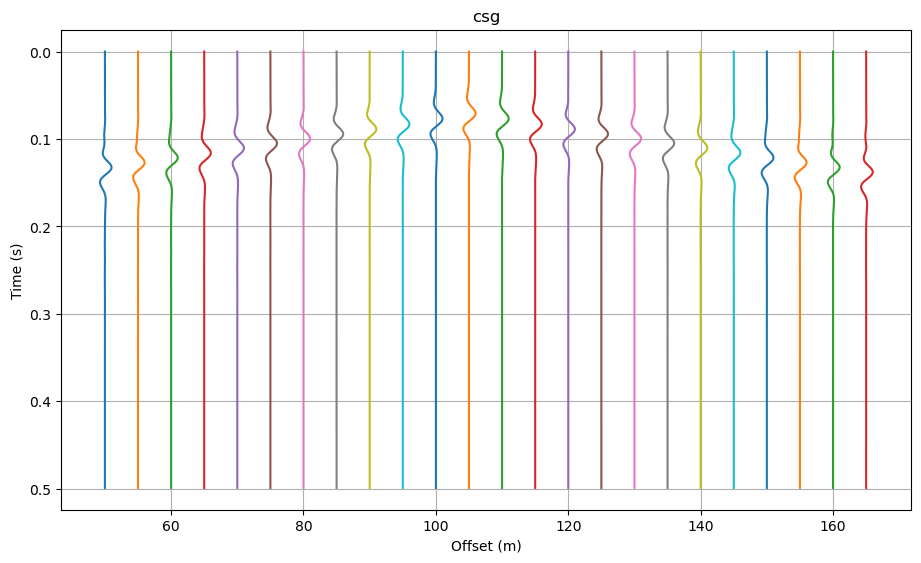

In [84]:
csg(obs[1,:,:], receiver, time, duration = 1, title = "csg", show_legend = False)

CFWI

In [57]:
vs_c = vs_inv.clone()
vs_c.requires_grad = True

In [85]:
n_epoch = 1000
lr = 1e-2
optimizer_c = torch.optim.Adam([vs_c], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_c,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
loss_fn = torch.nn.MSELoss()
losses = []

In [86]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_c.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_c, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    loss = loss_fn(syn, obs)
    losses.append(loss.item())
    loss.backward()
    if vs_c.grad is not None:
            torch.nn.utils.clip_grad_value_(vs_c, torch.quantile(vs_c.grad.detach().abs(), 0.98))
    optimizer_c.step()
    scheduler.step(loss.item())
    
    with torch.no_grad():
            vs_c.clamp_(min=200)

100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


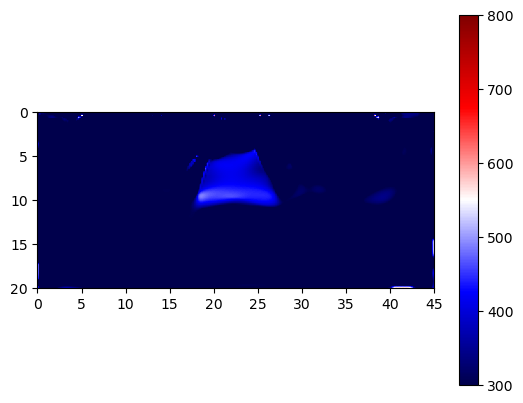

In [60]:
 plt.figure()
plt.imshow(vs_c.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

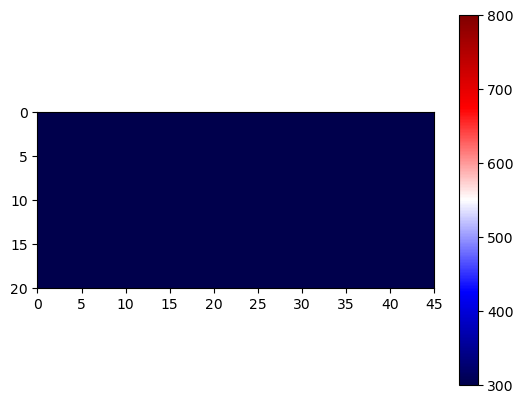

In [46]:
plt.figure()
plt.imshow(vs_inv.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

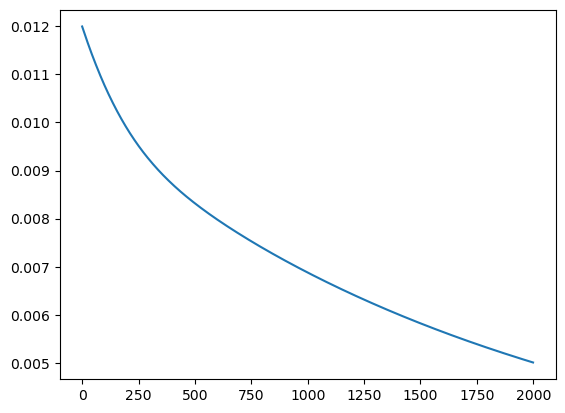

In [23]:
plt.figure()
plt.plot(losses)
plt.show()

# MFWI

In [87]:
def low_cut(signal: torch.Tensor,
            lowcut: float,
            dt: float,
            device: str) -> torch.Tensor:
    """
    PyTorch 기반 Low-Cut (High-Pass) 필터 (FFT 방식)

    Args:
        signal (torch.Tensor): 입력 신호 (shape: [batch, channels, time])
        lowcut (float): Low cutoff frequency (Hz)
        dt (float): 샘플링 간격 (s)
        device (str): "cpu" 또는 "cuda"
    Returns:
        torch.Tensor: Low-Cut 필터링된 신호
    """
    n = signal.shape[-1]
    freqs = torch.fft.fftfreq(n, d=dt).to(device)
    fft_sig = torch.fft.fft(signal, dim=-1)
    # lowcut 이상 주파수만 통과
    mask = freqs.abs() >= lowcut
    fft_sig = fft_sig * mask.unsqueeze(0).unsqueeze(0)
    return torch.fft.ifft(fft_sig, dim=-1).real.squeeze(0)

In [92]:
vs_m = vs_inv.clone()
vs_m.requires_grad = True

f = [20, 40, 60, 80, 100]
n_epoches = [1000, 2000, 3000, 4000, 5000]
lr = 1
optimizer_m = torch.optim.Adam([vs_m], lr=lr)
scheduler_m = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_m,
    mode='min',
    factor = 0.5,
    patience = 5,
)
loss_fn_m = torch.nn.MSELoss()
losses_m = []

In [93]:
for f0, n_epoch in zip(f, n_epoches):
    # obs_low는 루프 밖이나 맨 위에서 한 번만 계산해도 됩니다.
    obs_low = low_cut(obs, f0, dt, device)
    
    for epoch in range(n_epoch):
        optimizer_m.zero_grad() # 역전파 전에 그래디언트 초기화
        
        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_m, rho_f),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot,
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0, 10, 10, 10]
        )[-2]
        
        syn = normalized_shot_gather(syn)
        
        # 수정된 부분: syn을 필터링합니다.
        syn_low = low_cut(syn, f0, dt, device) 
        
        loss = loss_fn_m(syn_low, obs_low)
        losses_m.append(loss.item())
        
        loss.backward()
        optimizer_m.step()
        scheduler_m.step(loss.item())
        
        with torch.no_grad():
            vs_m.clamp_(min=200)

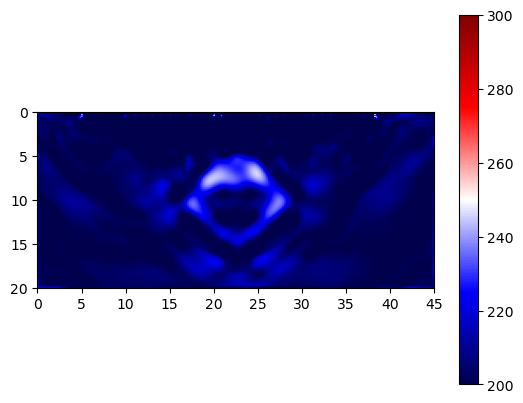

In [94]:
plt.figure()
plt.imshow(vs_m.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

# EFWI

In [29]:
import torch.nn as nn
class EnvelopeLoss(nn.Module):
    """
    관측 파형과 모델링 파형의 Envelope 차이를 계산하는 PyTorch Loss 클래스입니다.
    E(t) = (u(t)^2 + H[u(t)]^2)^(p/2)
    Loss = MSE(E_obs, E_syn)
    """
    def __init__(self, p: float = 1.0):
        """
        Args:
            p (float): Envelope 계산 시 적용할 지수 (기본값: 1.0)
        """
        super().__init__()
        if p <= 0:
            raise ValueError("지수 'p'는 양수여야 합니다.")
        self.p = p
        self.mse_loss = nn.MSELoss()

    def _calculate_envelope(self, signal: torch.Tensor) -> torch.Tensor:
        """Helper-function to compute the envelope of a signal tensor."""
        if signal.dim() != 3:
            raise ValueError("입력 신호는 3차원 텐서(n_shot, n_rec, n_t)여야 합니다.")

        n = signal.size(-1)
        # Hilbert transform via FFT
        fft = torch.fft.fft(signal, n=n, dim=-1)

        h = torch.zeros(n, device=signal.device, dtype=signal.dtype)
        h[0] = 1
        # Create frequency-domain filter for Hilbert transform
        if n % 2 == 0:
            h[1:n // 2] = 2
            h[n // 2] = 1
        else:
            h[1:(n + 1) // 2] = 2
        
        fft = fft * h.view(1, 1, -1) # Apply filter via broadcasting
        analytic_signal = torch.fft.ifft(fft, n=n, dim=-1)

        # Envelope is the magnitude of the analytic signal
        envelope = torch.sqrt(signal**2 + analytic_signal.imag**2)
        
        return envelope**self.p

    def forward(self, syn: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        모델링 파형(syn)과 관측 파형(obs)의 envelope loss를 계산합니다.
        """
        env_syn = self._calculate_envelope(syn)
        env_obs = self._calculate_envelope(obs)
        
        return self.mse_loss(env_syn, env_obs)

In [30]:
vs_e = vs_inv.clone()
vs_e.requires_grad = True

In [31]:
n_epoch = 2000
lr = 1e-2
optimizer_e = torch.optim.Adam([vs_e], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_e,
    mode = 'min',
    factor = 0.5,
    patience = 5,
)
loss_fn_e = EnvelopeLoss()
losses_e = []

In [32]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_e.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_e, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    
    loss = loss_fn_e(syn, obs)
    losses_e.append(loss.item())
    loss.backward()
    optimizer_e.step()
    scheduler.step(loss.item())

  1%|▏         | 28/2000 [00:05<06:04,  5.41it/s]


ValueError: cannot convert float NaN to integer

In [ ]:
plt.figure()
plt.imshow(vs_e.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax=V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_e.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")